# Udacity Nanodegree Program, Data Analyst

# Project 7: Machine Learning

# Identify Fraud from Enron Email 

## Dataset

The project is focused on Enron scandal, possibly the biggest cracked corporate fraud, where the goal of this project is to find out (or at least try to) who are persons of interest in this fraud case. As persons of interest (further reffered only as POI) are considered individuals who were indicted or was reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity. When estimating whether person is POI or not, application of machine learning (ML) techniques could help us tremendously. There are several reasons for using ML, but these two seems to me as the key ones: strong performance of ML algorithms and wide range of use-cases (classification, regression, natural language processing, image processing, etc.). 


To get some intuition about dataset here are some of the important characteristics: <br>
- 146 observations (ex employees of Enron)
- 21 features (originally)
- 4 features were used in classifier
- 3 new features were created

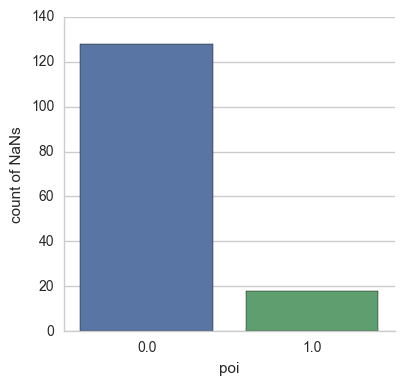

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import pickle
sys.path.append("../tools/")
%matplotlib inline 

from feature_format import featureFormat, targetFeatureSplit

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

data = pd.DataFrame.from_dict(data_dict, orient="index")
df = data

for col in df:
    if col != "email_address":
        df[col] = df[col].apply(float, 1)     

# count of NaNs
sns.set(style="whitegrid")
g = sns.factorplot("poi", data=df, kind="count")
g = g.set_axis_labels("poi", "count of NaNs")

And below set of features sorted by number of NaNs.

In [2]:
#count number of nans within each feature
nans_f = pd.Series(df.isnull().sum(axis=0), name="nans")
nans_f = nans_f.sort_values(ascending=False)
nans_f

loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
long_term_incentive           80
bonus                         64
from_poi_to_this_person       60
shared_receipt_with_poi       60
to_messages                   60
from_this_person_to_poi       60
from_messages                 60
other                         53
expenses                      51
salary                        51
exercised_stock_options       44
restricted_stock              36
total_payments                21
total_stock_value             20
email_address                  0
poi                            0
Name: nans, dtype: int64

Some of the features are consisted mainly by NANs (*loan_advances*, *restricted_stock_deferred*, *deferral_payment*s, so there is a number of options what to do with them. I decided to remove *loan_advances* from dataset as it has almost all values equal to NAN, *email_address* and *other* were removed as well as I do not see any information value in them. Rest of the features were preserved in the dataset for now.

In [3]:
nans_o = pd.Series(df.isnull().sum(axis=1), name="nans")
nans_o = nans_o.sort_values(ascending=False)
nans_o

LOCKHART EUGENE E                19
GRAMM WENDY L                    17
WROBEL BRUCE                     17
WODRASKA JOHN                    17
THE TRAVEL AGENCY IN THE PARK    17
WHALEY DAVID A                   17
SCRIMSHAW MATTHEW                17
CHRISTODOULOU DIOMEDES           16
CLINE KENNETH W                  16
GILLIS JOHN                      16
SAVAGE FRANK                     16
WAKEHAM JOHN                     16
CHAN RONNIE                      15
MEYER JEROME J                   15
BLAKE JR. NORMAN P               15
PEREIRA PAULO V. FERRAZ          15
FUGH JOHN L                      15
MENDELSOHN JOHN                  15
LOWRY CHARLES P                  15
GATHMANN WILLIAM D               15
YEAP SOON                        15
URQUHART JOHN A                  15
WINOKUR JR. HERBERT S            15
LEMAISTRE CHARLES                14
BADUM JAMES P                    14
NOLES JAMES L                    14
DUNCAN JOHN H                    14
PRENTICE JAMES              

From list above is clear that LOCKHART EUGENE E (all the features are NaNs) and THE TRAVEL AGENCY IN THE PARK (not a person) have no information value and thus I will get rid of them.

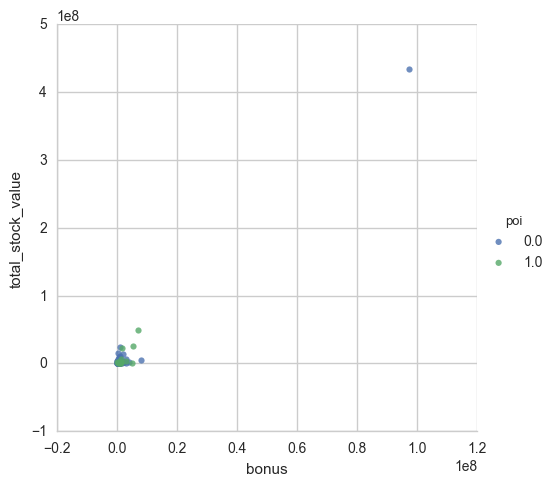

TOTAL              97343619.0
LAVORATO JOHN J     8000000.0
LAY KENNETH L       7000000.0
Name: bonus, dtype: float64

In [4]:
sns.lmplot("bonus", "total_stock_value", data=df, fit_reg=False, hue="poi")
plt.xlabel("bonus")
plt.ylabel("total_stock_value")
plt.show()

outliers = df.nlargest(3, "bonus")
outliers["bonus"]

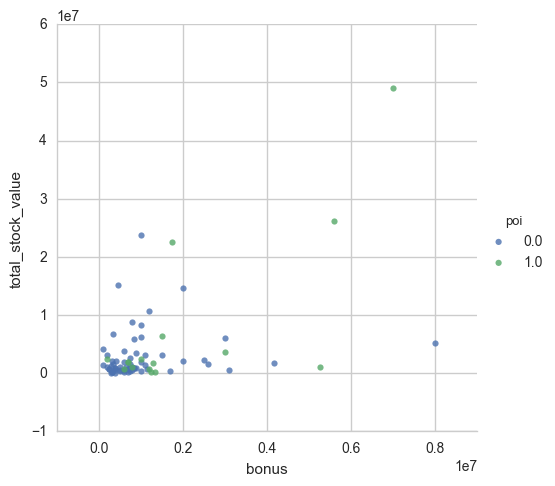

LAVORATO JOHN J       8000000.0
LAY KENNETH L         7000000.0
SKILLING JEFFREY K    5600000.0
Name: bonus, dtype: float64

In [5]:
df = df.drop(["TOTAL", "LOCKHART EUGENE E", "THE TRAVEL AGENCY IN THE PARK"])

sns.lmplot("bonus", "total_stock_value", data=df, fit_reg=False, hue="poi")
plt.xlabel("bonus")
plt.ylabel("total_stock_value")
plt.show()

outliers = df.nlargest(3, "bonus")
outliers["bonus"]

Regarding outliers, I removed one clear outliers - TOTAL, LOCKHART EUGENE E and THE TRAVEL AGENCY IN THE PARK where I am 100% sure that I do not want to include into model. 
Rest of the data were leaved in.

## Features

I ended up with these features: *exercised_stock_options*, *total_stock_value* and *deferred_income* which proved their ability to discriminate quite well. And it seems completely logical as the used features are the ones with the lower number of NANs. For obtaining those I used SelectKBest function with different scoring functions (chi2, using chi square statistics and f_classif computing ANOVA) and then tested characteristics of generated predictions using particular feature. 

Regarding new features:<br>
I come up with a few new features, first is called simply *nans* as it counts number of NANs within each person. The hypothesis was that there could be any pattern, such as people with more NANs (there is less information about them) tends to be POI in more cases (hypothesis does not work as I thought, but the feature seems to have some discriminatory power). Second feature is *to_poi_ratio* which is a proportion of messages sent to POI on total and third feature *from_poi_ratio* which is proportion of messages received from POI on total. Both are basically calculated out of two of the initial features, so I believe they have stronger information value now. Logic behind those two features is similar, people in intenser communication with POIs are more likely POI too (hypothesis). Between best 10 features according to SeleckKBest were also *to_poi_ratio* and *nans* (to_poi_ration [3rd] and nans [7th]), nevertheless after some testing (which might be found below) none of the new features is included in the model.

Regarding feature selection:<br>
To get the features which carry the signal I involved selection algorithm - SelectKBest from sklearn library. I created two selectors, one using "chi2" scoring function and one using ANOVA scoring function. Then I printed the sorted features by score - so I basically used the SelectKBest only for generating the scores. Decision which features to pick was based on scores and also I examined how the particular feature affect the model characteristics (accuracy, precision, recall). Could be find below. 

Regarding feature scaling:<br>
But before features were selected, the feature scaling was executed, using MinMaxScaler from sklearn library. Basically there are two kinds of features. The first are ones expressed by monetary units or money and could reach very high numbers (*salary*, *bonus*, etc.). The second ones are connected to number of sent or received emails (*from_messages*, *to_messages*), so the scale of those numbers is completely different. It is obvious that those kinds of features are incomparable and that is clear reason why perform feature scaling.

Hand in hand with feature scaling I also perform imputation of NaN values within the dataset. NaN values within all features were imputed by median value (except from *director_fees* which made me more sense to impute with 0). This caused that those features with more NaNs are wery weak in discriminating wheter the person is POI or not and thus will be less likely included in top k features.

In [12]:
df = data.drop(["email_address", "other", "loan_advances"], 1)
df = df.drop(["TOTAL"])
# creating a new features
nans = pd.Series(df.isnull().sum(axis=1), name="nans")
df = df.join(nans)

to_poi_ratio = pd.Series(df["from_this_person_to_poi"]/df["from_messages"], \
                         name="to_poi_ratio")
df = df.join(to_poi_ratio)
from_poi_ratio = pd.Series(df["from_poi_to_this_person"]/df["to_messages"], \
                           name="from_poi_ratio")
df = df.join(from_poi_ratio)

# feature scaling
df["director_fees"] = df["director_fees"].fillna(0)
from sklearn import preprocessing
imp = preprocessing.Imputer(missing_values=np.nan, strategy='median', axis=0)
scaler = preprocessing.MinMaxScaler()
df_imputed = pd.DataFrame(imp.fit_transform(df), \
                          index=df.index, columns=df.columns)
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), \
                         index=df.index, columns=df.columns)
poi = df["poi"] 
df_scaled["poi"] = poi

# feature selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2
selector1 = SelectKBest(f_classif, k=10)
selector2 = SelectKBest(chi2, k=10)
top_features1 = selector1.fit_transform(df_scaled, df_scaled["poi"])
top_features2 = selector2.fit_transform(df_scaled, df_scaled["poi"])
mask1 = selector1.get_support()
mask2 = selector2.get_support()
columns1 = []
columns2 = []
for col in range(len(df.columns)):
    if mask1[col] == True:
        columns1.append(df.columns[col])
    if mask2[col] == True:
        columns2.append(df.columns[col])
sc1 = pd.DataFrame(selector1.scores_, columns=["anova"], index=df.columns)
sc1 = sc1.sort_values(by=["anova"], ascending=False)
sc2 = pd.DataFrame(selector2.scores_, columns=["chi2"], index=df.columns)
sc2 = sc2.sort_values(by=["chi2"], ascending=False)

sc1[1:11]

,anova
exercised_stock_options,27.678401
total_stock_value,23.920241
to_poi_ratio,16.194476
bonus,16.135833
salary,11.064059
deferred_income,10.479953
nans,9.665694
restricted_stock,8.582427
long_term_incentive,8.582407
total_payments,8.507453


In [11]:
sc2[1:11]

,chi2
exercised_stock_options,5.987562
total_stock_value,5.084427
to_poi_ratio,2.720786
total_payments,2.508275
bonus,2.380356
director_fees,1.477491
nans,1.320943
long_term_incentive,1.151095
shared_receipt_with_poi,1.139038
from_this_person_to_poi,0.820472


I used the SelectKBest to generate scores for all the features and then I printed features sorted by score. The 10 best features are printed above in the tables. Two out of my created features ended up there (to_poi_ratio [3rd] and nans [7th]) which might signalize their significance, nevertheless in the final model none of them was used. 

I avoided to trying all of the possible k's (as a parameter of SelectKBest) and instead of that I tried the best features from the sorted lists above and examined their effect on the model characteristics (accuracy, precision, recall). Based on wheter feature significantly improved the quality of predictions made by model I decided to include/not include the feature in the final model. That examination could be find below.

Below are results of model (*Naive Bayes*), when different features were used: <br>

*Baseline:* <br>
[total_stock_value, exercised_stock_options] - Accuracy: 86%, Precision: 45%, Recall: 28% <br>

*bonus included:* <br>
[total_stock_value, exercised_stock_options, bonus] - Accuracy: 85%, Precision: 44%, Recall: 34% <br>
resume: positive effect on Recall

*to_poi_ratio included:* <br>
[total_stock_value, exercised_stock_options, to_poi_ratio] - Accuracy: 85%, Precision: 42%, Recall: 30% <br>
resume: minimal effect on Recall

*nans included:* <br>
[total_stock_value, exercised_stock_options, nans] - Accuracy: 86%, Precision: 44%, Recall: 28% <br>
resume: no significant effect

*salary included:* <br>
[total_stock_value, exercised_stock_options, salary] - Accuracy: 85%, Precision: 43%, Recall: 28% <br>
resume: no significant effect

*total_payments included:* <br>
[total_stock_value, exercised_stock_options, total_payments] - Accuracy: 85%, Precision: 41%, Recall: 24% <br>
resume: negative effect on both Recall and Precision

*deferred_income included:* <br>
[total_stock_value, exercised_stock_options, deferred_income] - Accuracy: 87%, Precision: 51%, Recall: 39% <br>
resume: positive effect on both Recall and Precision

*director_fees included:* <br>
[total_stock_value, exercised_stock_options, director_fees] - Accuracy: 24%, Precision: 15%, Recall: 100% <br>
resume: positive effect on Recall, negative on Precision and Accuracy

*long_term_incentive included:* <br>
[total_stock_value, exercised_stock_options, long_term_incentive] - Accuracy: 85%, Precision: 43%, Recall: 29% <br>
resume: no significant effect

*both deferred_income and bonus included:* <br>
[total_stock_value, exercised_stock_options, deferred_income, bonus] - Accuracy: 87%, Precision: 49%, Recall: 39% <br>

**Final features used in the model: <br>
[total_stock_value, exercised_stock_options, deferred_income] - Accuracy: 87%, Precision: 51%, Recall: 39% **<br>

## Algorithm

The comparison was performed within these four algorithms: *Adaboost*, *SVM*, *Decision tree*, and *Naive Bayes* classifier. Below are best parameters found by GridSearchCV and accuracy of model. Regarding accuracy the best result showed SVM and also very solid performance has Naive Bayes. But generally the differences between accuracy of particular models are not so big 
(~ 4%). At the end **as a final algorithm was chosed Naive Bayes** from reasons discussed further.

adaboost optimal parameters:  {'n_estimators': 150, 'learning_rate': 1.5}<br>
adaboost accuracy:  0.84<br>
SVM optimal parameters:  {'kernel': 'rbf', 'C': 150, 'gamma': 0}<br>
SVM accuracy:  0.89<br>
decision tree optimal parameters:  {'min_samples_split': 25}<br>
decision tree accuracy:  0.91<br>
naive bayes accuracy:  0.91<br>

The choice of proper algorithm is very important, nevertheless it is not all. To achieve good results, it is neccesery to choose appropriate parameters of model, what is called *parameter optimization*. I would say that using model with non optimal parameters is like cutting with blunt knife - you have the appropriate tool, but in inappropriate condition. Using of non optimal parameters could cause serious problems such as overfitting and significantly decrease the power of model. I performed parameter tuning by GridSearchCV, which is automated method of choosing the best parameters out of all possible parameters you define - that is why is it also called exhaustive method.  

## Validation and Evaluation

From my point of a view the calculation of accuracy is not enough in order to properly assess model performance, at least in most of the cases. Thus we also use different metrics to provide more complex picture about a quality of model. The most common evaluation metrics are probably Recall and Precision. Recall tells me what proportion of positive cases the model was able to predict out of total positive cases. So in this project it tells me what proportion of POIs out of all POIs the model could predict. On the other hand Precision shows what proportion out of all the predicted positive cases (predicted POI) are truly positive cases (actual POI) 

I have already used the word - *overfitting*. Which is something I would like to always avoid. The problem with overfitted model is that the model is very good predictor, but only on the dataset on which was trained on. That is not exactly what I want from my model. I want my model being good predictor "on whatever data" you throw in it. So in order to avoid overfitting I chose the most common way, so called *validation*. I really like this concept, it has two very likeable attributes - it is simple and smart. And generally it is nothing else than separating your dataset into more part, lets say 2. The first part is used for training of the model and the second for testing how good is the model at predicting. Generally quite good question is in what proportion to divide the dataset. Well, a lot of people use around 70% on training and 30% on testing, I used that too. Besides the above mentioned simple division into 2 groups, there also more sophisticated methods. Such as StratifiedShuffleSplit, which firstly shuffle the dataset and then split it into two groups, this shuffle-split procedure performs iteratively for defined number of times. This method also takes into account frequency of postivive/negative cases in the dataset, which is very usefull in case of "rare" positive or negative cases.

I tried both of above mentioned methods in my project. Relatively consistent performance showed only Naive Bayes within all my attempts and changes of parameters (random_state, number of splits). Here are scores of algorithms trained on training set cross validated using simple split.

adaboost precision score:  0.25<br>
adaboost recall score:  0.25<br>
SVM precision score:  0.5<br>
SVM recall score:  0.25<br>
decision tree precision score:  1.0<br>
decision tree recall score:  0.25<br>
naive bayes precision score:  0.4<br>
naive bayes recall score:  0.5<br>

Even though some of the algorithms showed better accuracy compared to Naive Bayes, they did not end up so good in next evaluations. That was confirmed by running tester.py script which proved that those algorithms obtained worse recall/precision scores, below 0.3 level. Those are reasons why **I chose Naive Bayes as a final algorithm**.

## Reflection

For me quite surprise that Naive Bayes overperformed other algorithms. I think mainly due to the simplicity and relatively good generalization ability of this model. However when I am considering my level of konwledge and intuition in ML, it is very likely that I missed more than a few things or did them not quite good. So in future work I would definitely try to come up with some different features as I believe the feature engineering is the key to better results of ML models. And also I will try to keep on track and get even more into ML.

## Sources

1) https://seaborn.pydata.org/index.html <br>
2) http://scikit-learn.org/stable/documentation.html <br>
3) https://pandas.pydata.org/ <br>
4) https://matplotlib.org/devdocs/index.html <br>

Created by Martin Rypar <br>
13.11.2017